# SHAP Analysis and Results

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from src.exp import compute_shap_values

/Users/silvanoquarto/Desktop/PROJECTS/Churn-Prediction-Explanation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SHAP with XGBoost

* I implemented SHAP algorithm in Cross-Validation using XGBoost in order to use dataset with only numerical features
* From Global analysis:
    1. Tenure and contract type are in the top positions in the features importance plot, as expected
    2. It's a useful information that the most powerfull contract feature is Month-To-Month contract. Interesting also the high positions for payment methods, this is not expected
    3. In dependence plots for numerical features, you can see that:
        * In Tenure distributions, you can see that around 0.2 Tenure (~15/20 months) clients are most likely to stay with company
        * Clients with low Monthly Charges are most likely to stay with the company, and those with higher Monthly Charges are likely to churn
        * In Tenure and Month-to_Month Contract interaction, you can see that clients with this kind of contract are more likely to churn respect to the other types of contracts
    4. As you can see from beeswarm plot:
        * Contract with more than 2 years are more likely to stay
        * Clients who pay with mailed check and credit cards are more likely to stay
* From Local analysis:
    1. I implemented 3 different ways (decisio, force and waterfall plot) to see the same results according which factor is more important (better visualization or more information)
    2. You can see how features importance changes from a client to another and from global to local point of view: feature like Intern service type are now in top 3 and Contract Month-to-Month is in a lower position

In [2]:
# Import dataframe 

df = pd.read_excel("Data/CustomerChurn_Transformed.xlsx", index_col=0)
df.reset_index(drop= True, inplace=True)
df.tail(5)

,Tenure,Monthly Charges,Total Charges,Churn,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
7027,0.323944,0.662189,0.227521,0,1,0,0,1,0,1,...,1,0,1,0,0,1,0,0,0,1
7028,1.000000,0.845274,0.847461,0,1,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0
7029,0.140845,0.112935,0.037809,0,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
7030,0.042254,0.558706,0.033210,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
7031,0.915493,0.869652,0.787641,0,1,0,1,0,1,0,...,1,0,0,1,0,1,1,0,0,0


In [5]:
# Define input and label then split in training and test

X = df.drop(columns='Churn')
y = df['Churn']

In [3]:
# Compute the Shapley Values in a Stratified Cross-Validation for XGBoost

shap_df_sorted, expected_values_df_sorted = compute_shap_values(df, target_column='Churn', algorithm='xgboost', smote=True, n_splits=10)

--------------------
Fold 1:
Training XGBoost...
--------------------
--------------------
Fold 2:
Training XGBoost...
--------------------
--------------------
Fold 3:
Training XGBoost...
--------------------
--------------------
Fold 4:
Training XGBoost...
--------------------
--------------------
Fold 5:
Training XGBoost...
--------------------
--------------------
Fold 6:
Training XGBoost...
--------------------
--------------------
Fold 7:
Training XGBoost...
--------------------
--------------------
Fold 8:
Training XGBoost...
--------------------
--------------------
Fold 9:
Training XGBoost...
--------------------
--------------------
Fold 10:
Training XGBoost...
--------------------


In [9]:
# Saving results

shap_df_sorted.to_csv("Results/XGBoost_Shapley_Values_10Fold_CV.csv")
expected_values_df_sorted.to_csv("Results/XGBoost_Expected_Values_10Fold_CV.csv")

In [10]:
# Import results

shap_df_sorted = pd.read_csv("Results/XGBoost_Shapley_Values_10Fold_CV.csv", index_col=0)
expected_values_df_sorted = pd.read_csv("Results/XGBoost_Expected_Values_10Fold_CV.csv", index_col=0)

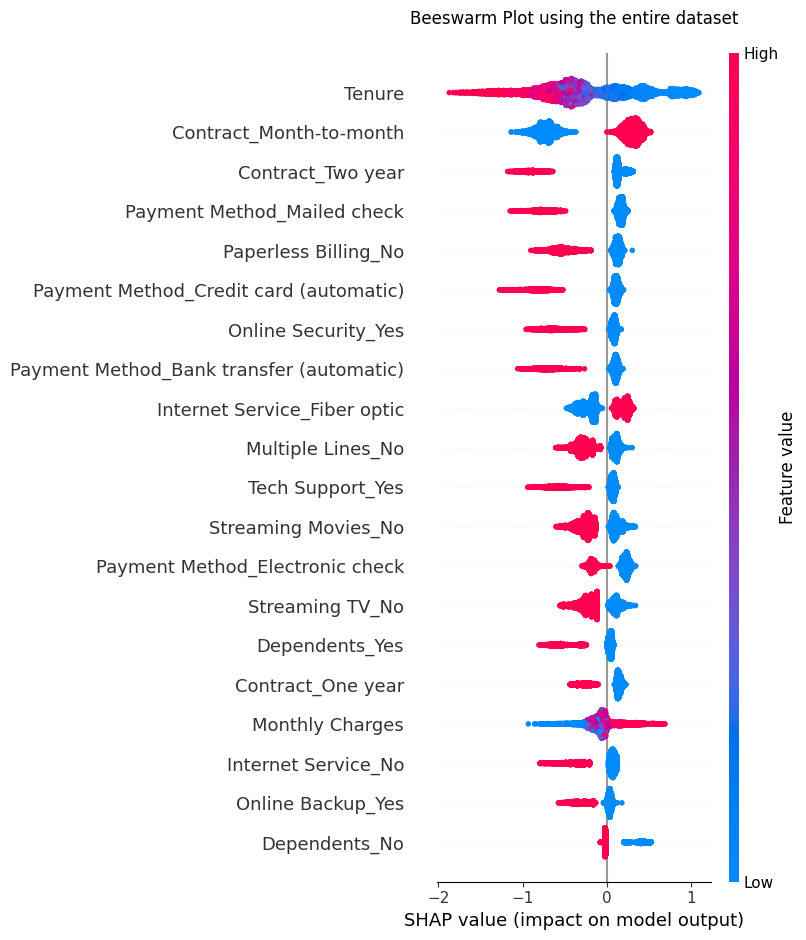

In [6]:
# Results visualization

# Beeswarm plot

plt.title(f"Beeswarm Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, show=False, plot_type="dot")

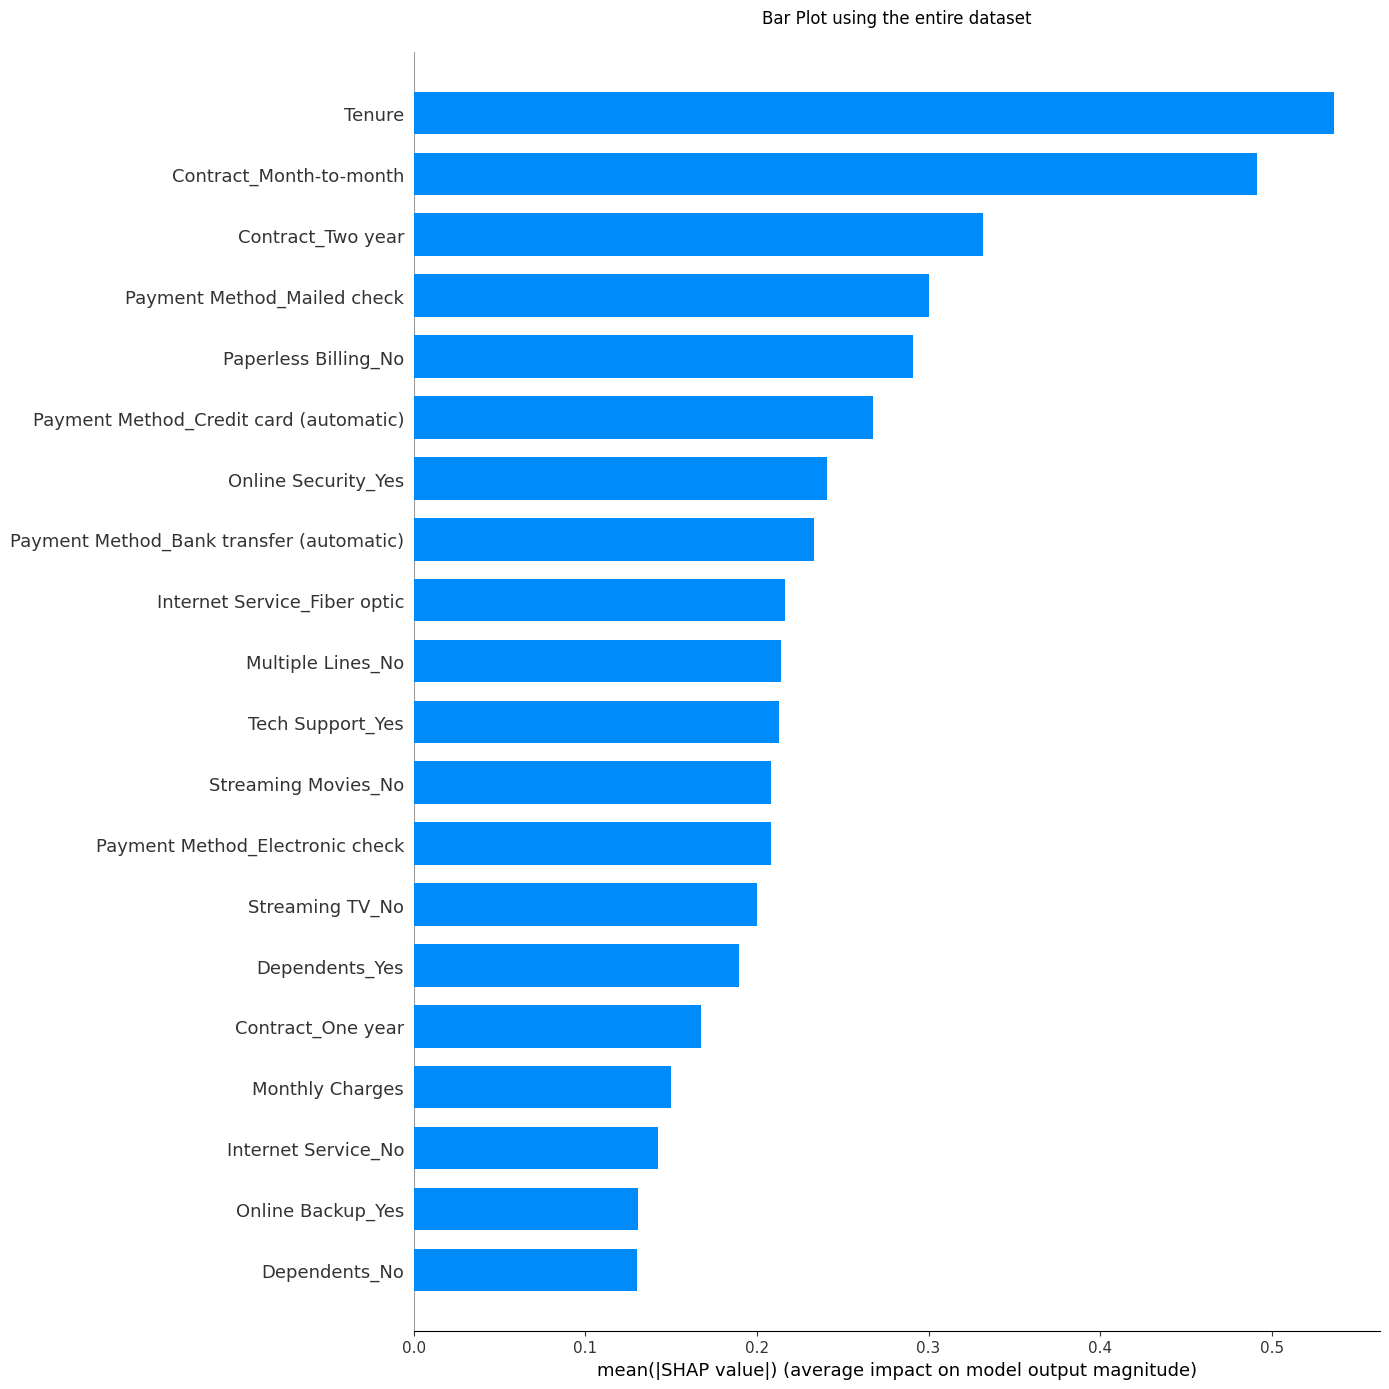

In [7]:
# Bar plot

plt.title(f"Bar Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, plot_type="bar", show=False, plot_size=(14,14))

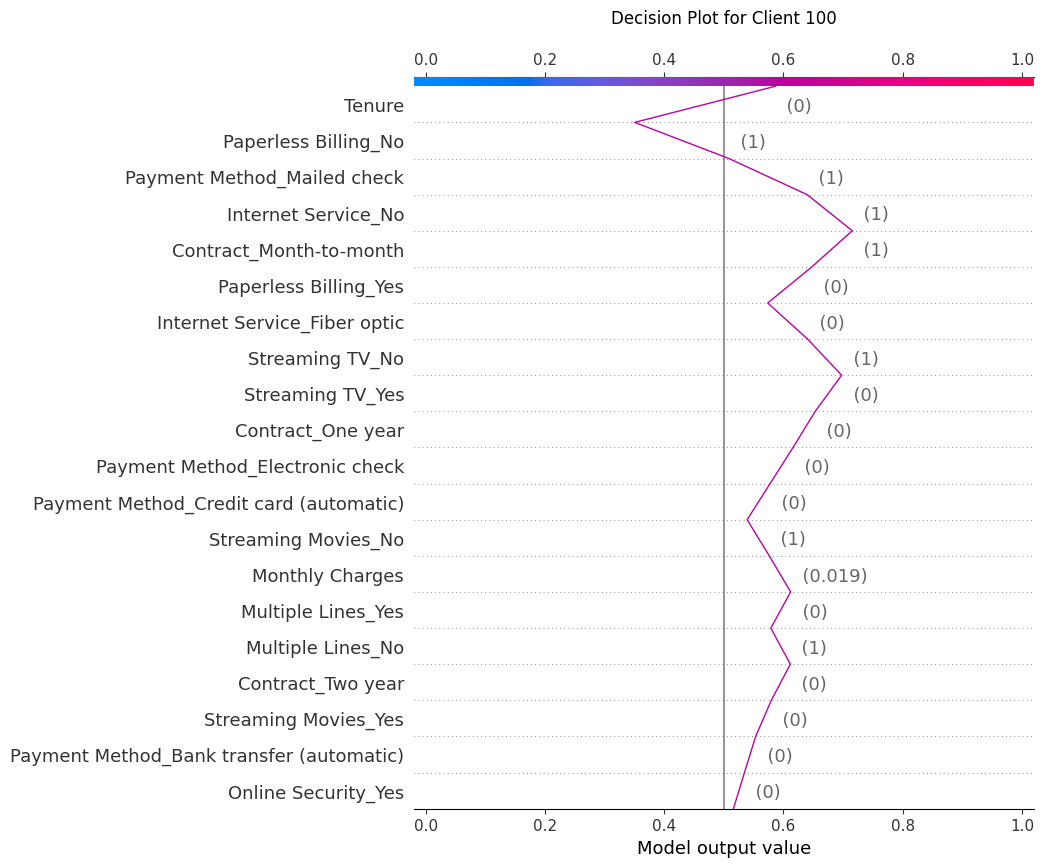

In [8]:
# Local explanation with Decision Plot

client = 100

plt.title(f"Decision Plot for Client {client}\n")

shap.decision_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit')

In [9]:
# Local Explanation with Force plot

shap.initjs()
shap.force_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit'
                   )

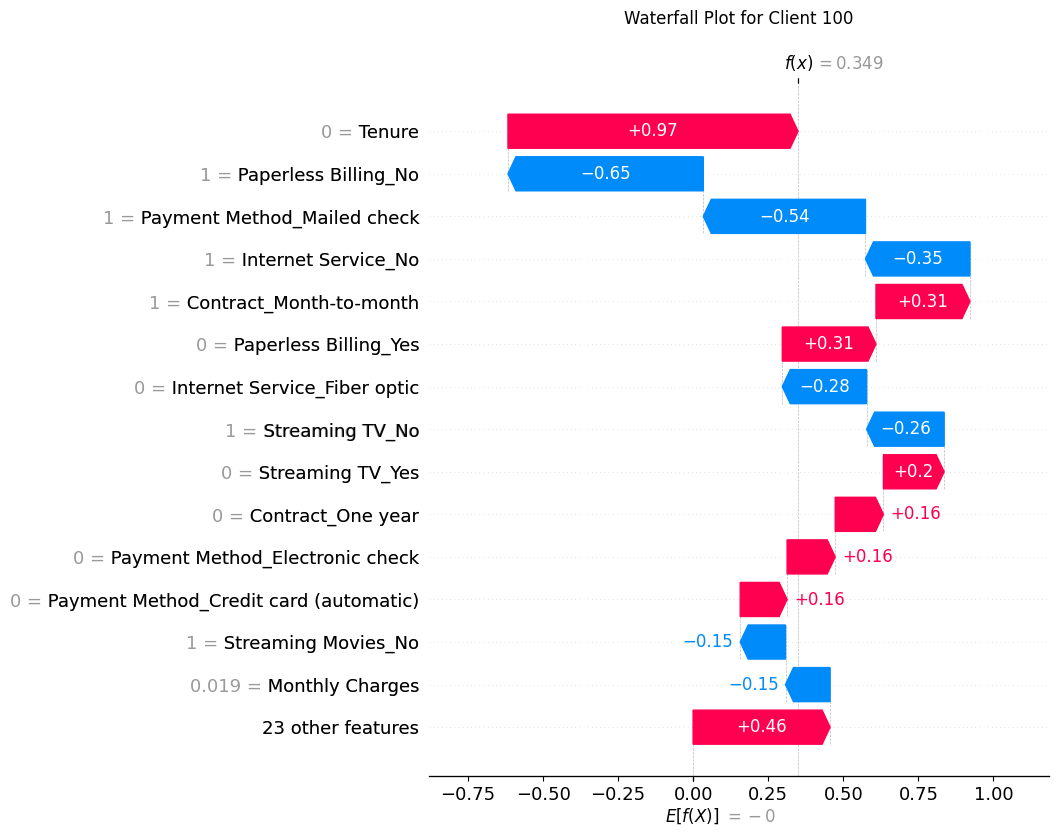

In [10]:
# Local Explanation with Waterfall plot

# For XGBoost the returned units for the Shapley values are in log-odds and Waterfall plot doesn't implement link = 'logit'

exp = shap.Explanation(
    shap_df_sorted.iloc[client].values,
    expected_values_df_sorted.iloc[client].values,
    X.iloc[client,:],
    feature_names=X.columns
)

plt.title(f"Waterfall Plot for Client {client}\n")

shap.waterfall_plot(exp, max_display=15)

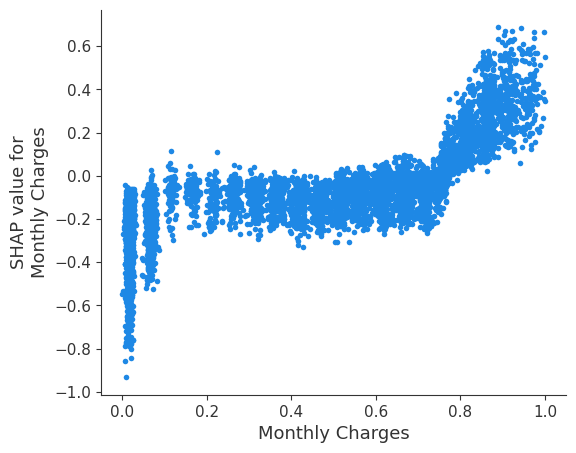

In [11]:
# Analysis on features using Dependence plot

feature_name = "Monthly Charges"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

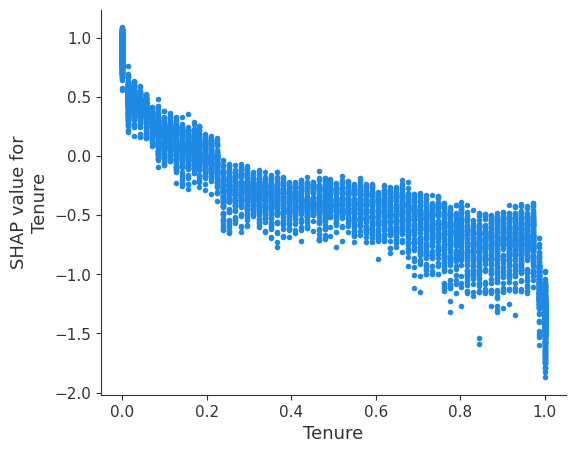

In [12]:
# Analysis on features using Dependence plot

feature_name = "Tenure"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

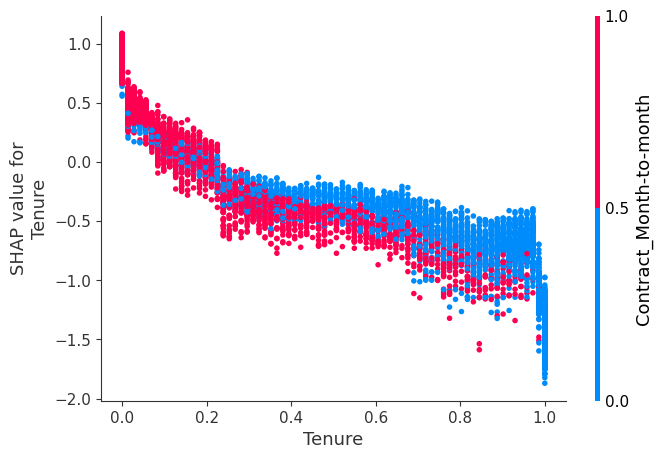

In [13]:
# Analysis on features using Dependence plot

feature_name = "Tenure"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index='Contract_Month-to-month')

## SHAP with CatBoost

* I implemented SHAP algorithm in Cross-Validation using CatBoost in order to handle the categorical features without encoding them
* From Global analysis:
    1. Total Charges and Tenure are in the top positions in the features importance plot, as expected
    2. Top 3 are Contract, Internet Service and Total Charges
    3. In dependence plots for numerical features, you can see that:
        * Clients with Monthly Charges around 80 US dollars are most likely to stay with the company, and those with over 100 US dollars are likely to churn
        * In Tenure and Contract interaction, you can see that clients with more than 1 or 2 years of contract are likely to stay, opposite behaviour for clients with month-to-month contract
    4. As you can see from beeswarm plot, there are some feature in grey colour. This is due to bacause they are categorical features and their behaviours are seen in dependence plots
        * Clients with Month-to-Month contract are most likely to churn
        * Clients with Two-Year contract are most likely to stay 
        * Clients with Fiber Optic Internet service are most likely to churn
        * Clients with No Internet service are most likely to stay
* From Local analysis:
    1. I implemented 3 different ways (decisio, force and waterfall plot) to see the same results according which factor is more important (better visualization or more information)
    2. You can see how features importance changes from a client to another and from global to local point of view: features like Total Charges and Tenure are in top 2 now for example.

In [14]:
# Import dataframe 

df = pd.read_excel("Data/CustomerChurn_Cleaned_Cat_and_Num.xlsx", index_col=0)
df.reset_index(drop= True, inplace=True)
df.tail(5)

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
7027,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7028,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7029,No,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7031,No,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


In [15]:
# Define input and label then split in training and test

X = df.drop(columns='Churn')
y = df['Churn']

In [17]:
# Compute the Shapley Values in a Stratified Cross-Validation for CatBoost

shap_df_sorted, expected_values_df_sorted = compute_shap_values(df, target_column='Churn', algorithm='catboost', smote=False, n_splits=10)

--------------------
Fold 1:
Training CatBoost...
--------------------
--------------------
Fold 2:
Training CatBoost...
--------------------
--------------------
Fold 3:
Training CatBoost...
--------------------
--------------------
Fold 4:
Training CatBoost...
--------------------
--------------------
Fold 5:
Training CatBoost...
--------------------
--------------------
Fold 6:
Training CatBoost...
--------------------
--------------------
Fold 7:
Training CatBoost...
--------------------
--------------------
Fold 8:
Training CatBoost...
--------------------
--------------------
Fold 9:
Training CatBoost...
--------------------
--------------------
Fold 10:
Training CatBoost...
--------------------


In [8]:
# Saving results

shap_df_sorted.to_csv("Results/CatBoost_Shapley_Values_10Fold_CV.csv")
expected_values_df_sorted.to_csv("Results/CatBoost_Expected_Values_10Fold_CV.csv")

In [14]:
# Import results

shap_df_sorted = pd.read_csv("Results/CatBoost_Shapley_Values_10Fold_CV.csv", index_col=0)
expected_values_df_sorted = pd.read_csv("Results/CatBoost_Expected_Values_10Fold_CV.csv", index_col=0)

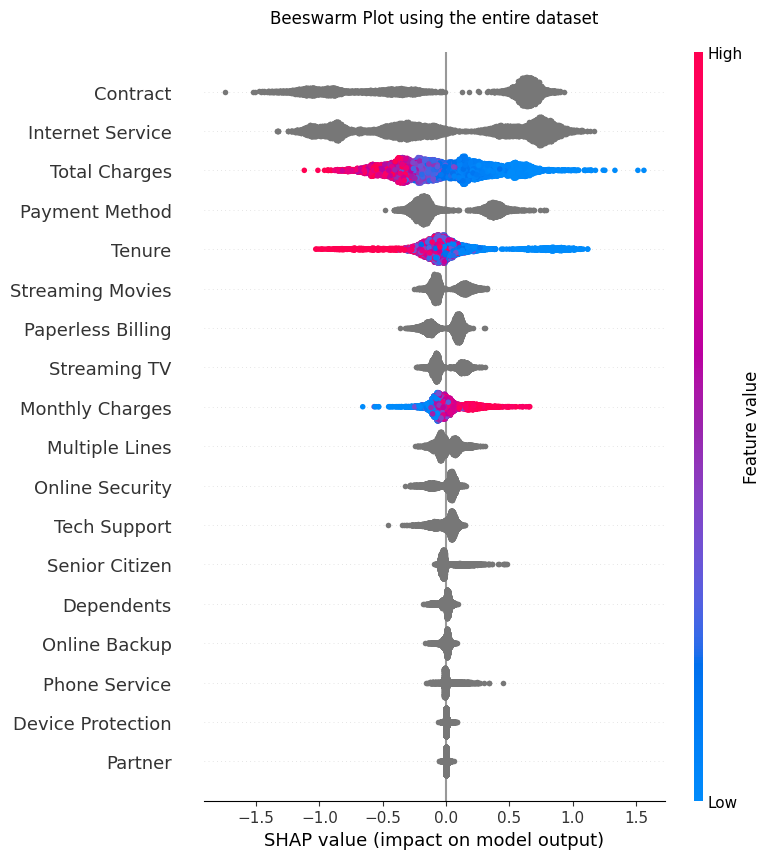

In [18]:
# Results visualization

# Beeswarm plot

plt.title(f"Beeswarm Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, show=False, plot_type="dot")

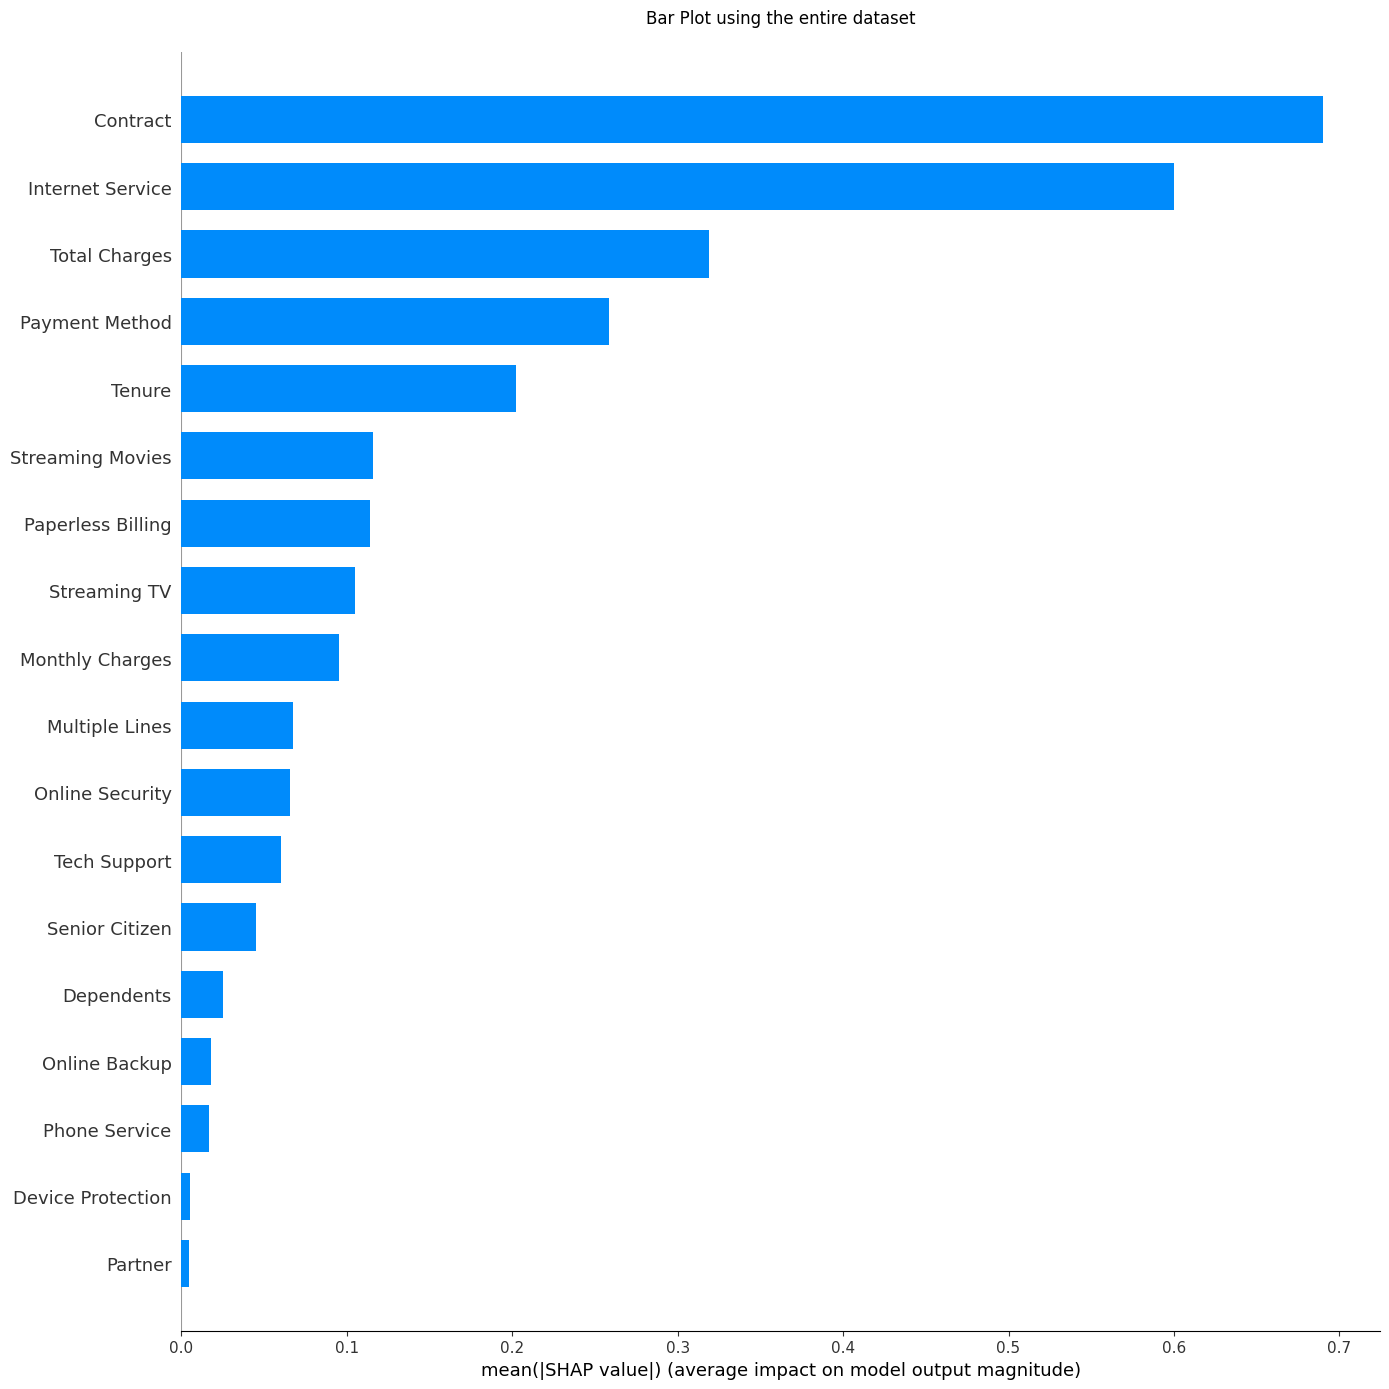

In [19]:
# Bar plot

plt.title(f"Bar Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, plot_type="bar", show=False, plot_size=(14,14))

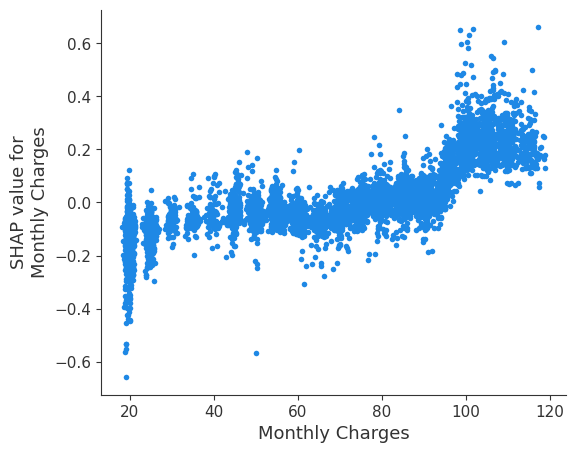

In [20]:
# Analysis on features using Dependence plot

feature_name = "Monthly Charges"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

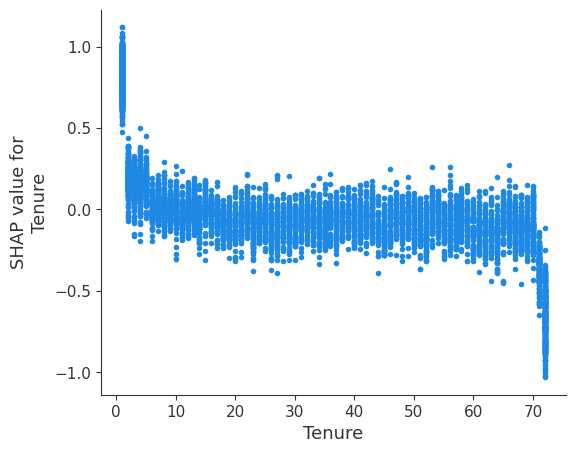

In [21]:
# Analysis on features using Dependence plot

feature_name = "Tenure"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

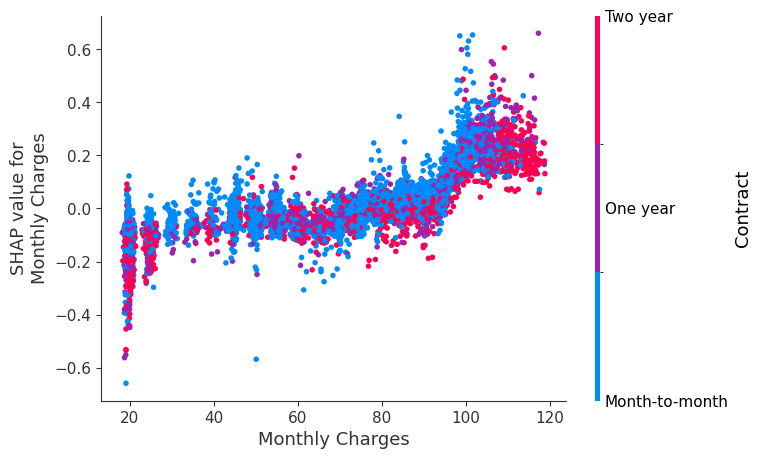

In [22]:
# Analysis on features using Dependence plot

feature_name = "Monthly Charges"
feature_to_compare = 'Contract'

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=feature_to_compare)

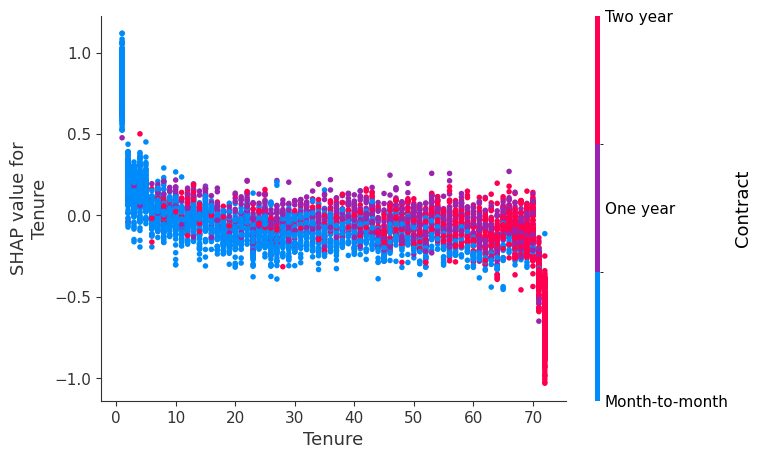

In [23]:
# Analysis on features using Dependence plot

feature_name = "Tenure"
feature_to_compare = 'Contract'

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=feature_to_compare)

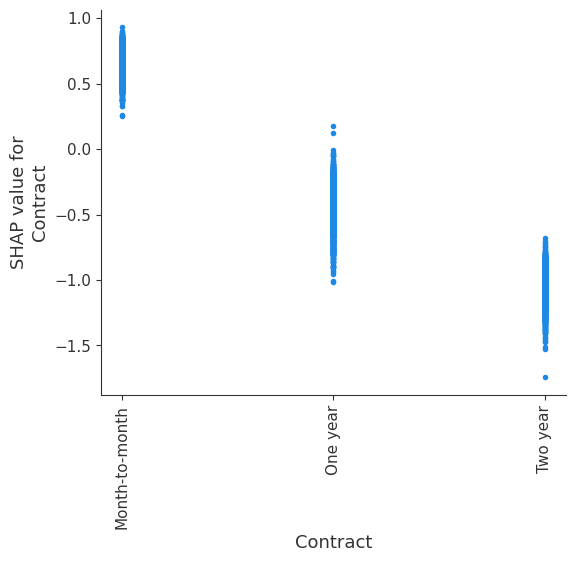

In [24]:
# Analysis on features using Dependence plot

feature_name = "Contract"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

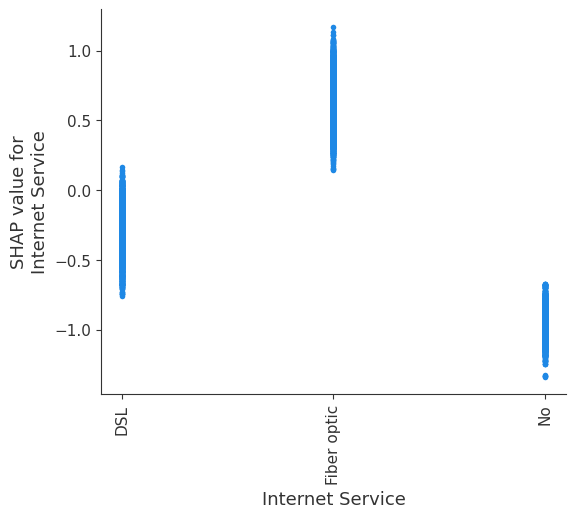

In [25]:
# Analysis on features using Dependence plot

feature_name = "Internet Service"

shap.dependence_plot(feature_name, shap_df_sorted.values, X, interaction_index=None)

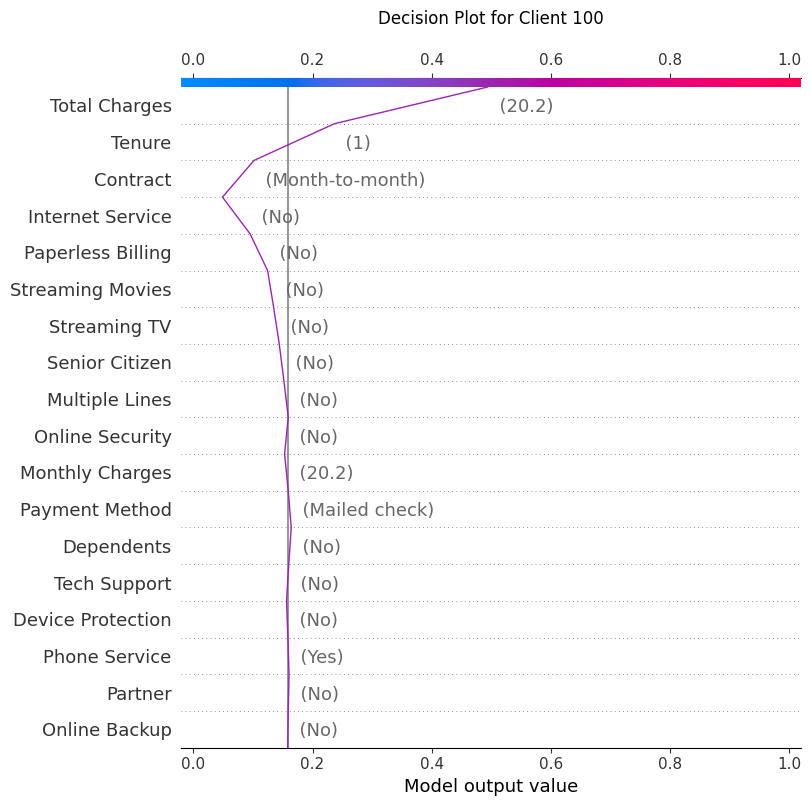

In [26]:
# Local explanation with Decision Plot

client = 100

plt.title(f"Decision Plot for Client {client}\n")

shap.decision_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit')

In [27]:
# Local Explanation with Force plot

shap.initjs()
shap.force_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit'
                   )

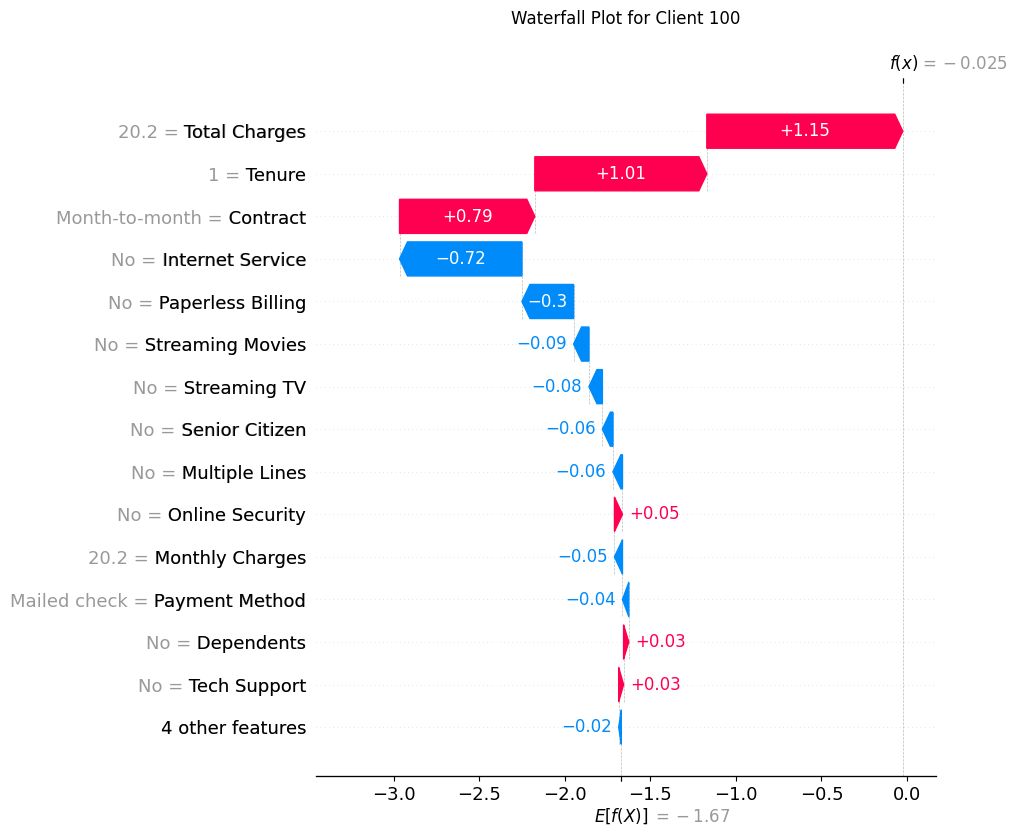

In [28]:
# Local Explanation with Waterfall plot

# For CatBoost the returned units for the Shapley values are in log-odds and Waterfall plot doesn't implement link = 'logit'

exp = shap.Explanation(
    shap_df_sorted.iloc[client].values,
    expected_values_df_sorted.iloc[client].values,
    X.iloc[client,:],
    feature_names=X.columns
)

plt.title(f"Waterfall Plot for Client {client}\n")

shap.waterfall_plot(exp, max_display=15)